Sometimes in regression we don't want to estimate the mean, but the upper/lower bound of your dataset, or some quantile value. This is where quantile regression comes to play. The idea is that rather than estimating the usual conditional mean via MSE or MAE, we will penalize it more heavily if the residual goes below certain threshold. Thus the prediction after training will gravitate toward that threshold value. 

In [2]:
! pip uninstall -y theano

Uninstalling Theano-1.0.4:
  Successfully uninstalled Theano-1.0.4


In [1]:
import gpustat
gpustat.print_gpustat()
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'
import random
random.seed(0)
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, Lambda
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import backend as K
import seaborn as sns
sns.set(style="white", color_codes=True)
from sklearn.ensemble import GradientBoostingRegressor

imperium-sm.hep.caltech.edu  Fri Aug  9 16:10:12 2019  418.67
[0] GeForce GTX 1080 | 21'C,   0 % |     1 /  8119 MB |
[1] GeForce GTX 1080 | 23'C,   0 % |     1 /  8119 MB |
[2] GeForce GTX 1080 | 24'C,   0 % |     1 /  8119 MB |
[3] GeForce GTX 1080 | 21'C,   0 % |     1 /  8119 MB |
[4] GeForce GTX 1080 | 24'C,   0 % |     1 /  8119 MB |
[5] GeForce GTX 1080 | 23'C,   0 % |     1 /  8119 MB |
[6] GeForce GTX 1080 | 24'C,   0 % |     1 /  8119 MB |
[7] GeForce GTX 1080 | 25'C,   0 % |     1 /  8119 MB |


Using TensorFlow backend.


Number of data points:  2000


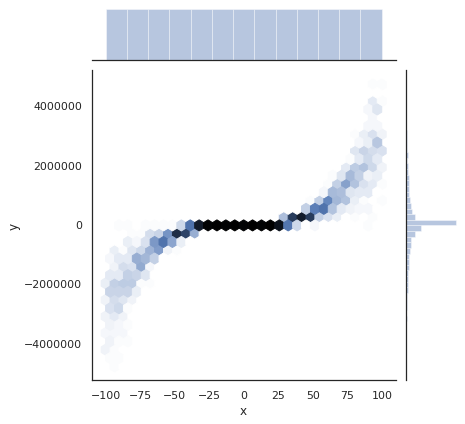

In [2]:
x = np.arange(-100,100, step=0.1)
y = 3+3*x*x*x + np.random.normal(0, np.absolute(np.power(x,3)))
yval = 3+3*x*x*x + np.random.normal(0, np.absolute(np.power(x,3)))
data = pd.DataFrame({'x':x, 'y':y, 'yval': yval})
sns.jointplot(x="x", y="y", data=data, kind='hex')

# Shuffle the dataset for training
idx = np.arange(len(x))
np.random.shuffle(idx)
x_train = x[idx]
y_train = y[idx]
y_trainval = yval[idx]
print("Number of data points: ", len(x))

In [91]:
def quantile_loss(target, pred):
    alpha = 0.99
    err = target - pred
    return K.tf.where(err>=0, alpha*err, (alpha-1)*err)

inputs = Input(shape=(1,))
hidden = Dense(1000, activation='relu')(inputs)
hidden = Dense(1000, activation='relu')(hidden)
hidden = Dense(1000, activation='relu')(hidden)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss=quantile_loss, optimizer='adam')
model.summary()

model.fit(x_train,y_train,  epochs=100, batch_size=1000, verbose=1, 
          callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
          validation_data=(x,yval))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
dense_59 (Dense)             (None, 1000)              2000      
_________________________________________________________________
dense_60 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_61 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 1001      
Total params: 2,005,001
Trainable params: 2,005,001
Non-trainable params: 0
_________________________________________________________________
Train on 2000 samples, validate on 2000 samples
Epoch 1/100
2000/2000 [==============================] - 1s 289us/step - loss: 38189

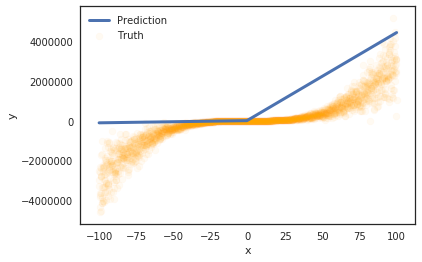

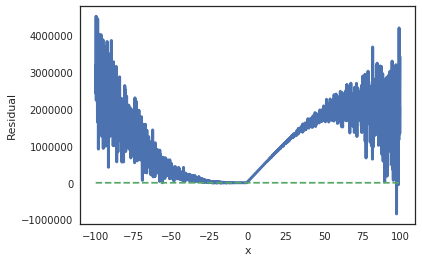

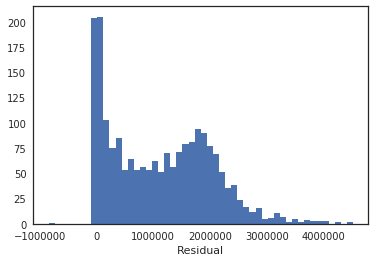

In [92]:
yhat = model.predict(x.reshape(-1,1))
plt.plot(x,yhat, linewidth=3, label='Prediction')
plt.scatter(x,yval, color='orange', label='Truth', alpha=0.05)
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
res_y = yhat.flatten()-yval
plt.plot(x, res_y, linewidth=3)
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.show()

plt.figure()
plt.hist(res_y, bins=50)
plt.xlabel("Residual")
plt.show()

This was caused by not having enough statistics. Let's try again with better statistics

Number of data points:  200000


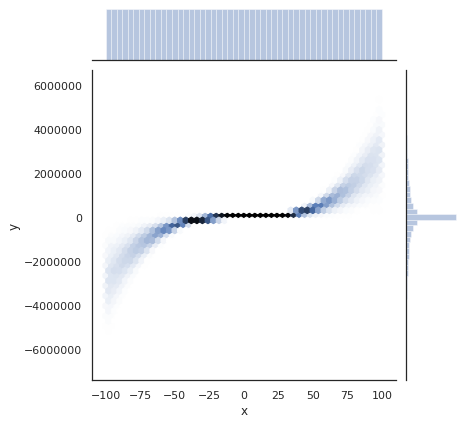

In [3]:
x = np.arange(-100,100, step=0.001)
y = 3+3*x*x*x + np.random.normal(0, np.absolute(np.power(x,3)))
yval = 3+3*x*x*x + np.random.normal(0, np.absolute(np.power(x,3)))
data = pd.DataFrame({'x':x, 'y':y, 'yval': yval})
sns.jointplot(x="x", y="y", data=data, kind='hex')

# Shuffle the dataset for training
idx = np.arange(len(x))
np.random.shuffle(idx)
x_train = x[idx]
y_train = y[idx]
y_trainval = yval[idx]
print("Number of data points: ", len(x))

In [4]:
def quantile_loss(target, pred):
    alpha = 0.99
    err = target - pred
    return K.tf.where(err>=0, alpha*err, (alpha-1)*err)

inputs = Input(shape=(1,))
hidden = Dense(1000, activation='relu')(inputs)
hidden = Dense(1000, activation='relu')(hidden)
hidden = Dense(1000, activation='relu')(hidden)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss=quantile_loss, optimizer='adam')
model.summary()

model.fit(x_train,y_train,  epochs=100, batch_size=1000, verbose=1, 
          callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
          validation_data=(x,yval))

W0809 16:10:26.920179 139881671300928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 16:10:26.961289 139881671300928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 16:10:26.967378 139881671300928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 16:10:27.027920 139881671300928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0809 16:10:27.053295 139881671300928 deprecation.py:323

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2000      
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1001      
Total params: 2,005,001
Trainable params: 2,005,001
Non-trainable params: 0
_________________________________________________________________


W0809 16:10:27.353549 139881671300928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 200000 samples, validate on 200000 samples
Epoch 1/100
200000/200000 [==============================] - 7s 35us/step - loss: 136031.2460 - val_loss: 11563.8647
Epoch 2/100
200000/200000 [==============================] - 1s 7us/step - loss: 11496.0487 - val_loss: 11390.0403
Epoch 3/100
200000/200000 [==============================] - 1s 7us/step - loss: 11406.1346 - val_loss: 11348.7286
Epoch 4/100
200000/200000 [==============================] - 1s 7us/step - loss: 11340.4377 - val_loss: 11302.3669
Epoch 5/100
200000/200000 [==============================] - 1s 7us/step - loss: 11303.2429 - val_loss: 11322.1285
Epoch 6/100
200000/200000 [==============================] - 1s 7us/step - loss: 11269.5924 - val_loss: 11204.2737
Epoch 7/100
200000/200000 [==============================] - 1s 7us/step - loss: 11229.1731 - val_loss: 11170.7793
Epoch 8/100
200000/200000 [==============================] - 1s 7us/step - loss: 11188.5463 - val_loss: 11118.8208
Epoch 9/100
200000/200000 

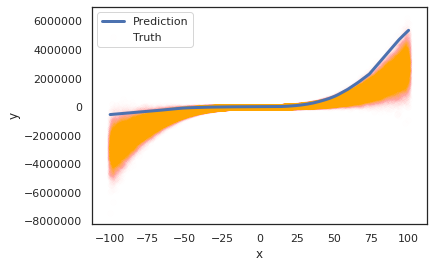

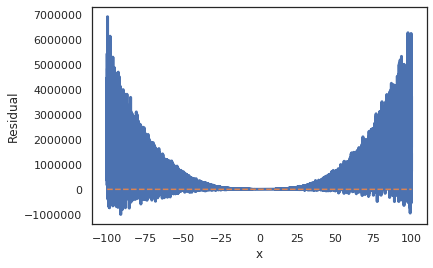

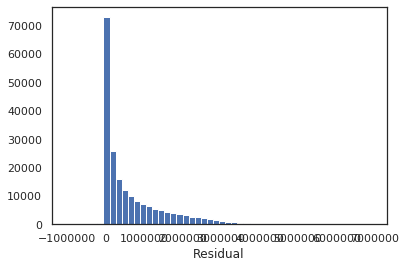

In [5]:
yhat = model.predict(x.reshape(-1,1))
plt.plot(x,yhat, linewidth=3, label='Prediction')
plt.scatter(x,yval, color='orange', label='Truth', alpha=0.005)
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
res_y = yhat.flatten()-yval
plt.plot(x, res_y, linewidth=3)
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.show()

plt.figure()
plt.hist(res_y, bins=50)
plt.xlabel("Residual")
plt.show()

Much better!

## BDT
You can also use BDT instead of NN since it's much faster.

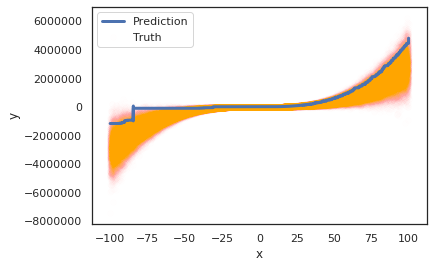

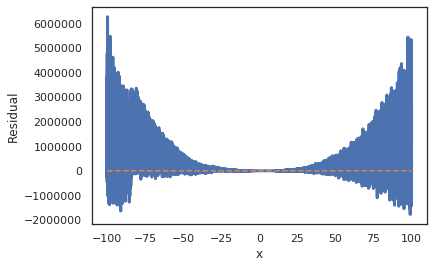

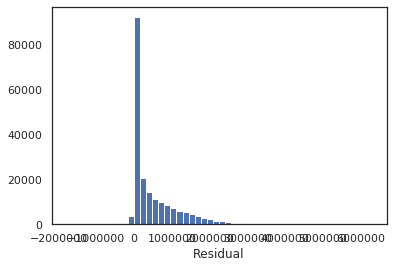

In [8]:
model =  GradientBoostingRegressor(loss='quantile', alpha=0.95)
model.fit(x_train.reshape(-1,1), y_train)
yhat = model.predict(x.reshape(-1,1))
plt.plot(x,yhat, linewidth=3, label='Prediction')
plt.scatter(x,yval, color='orange', label='Truth', alpha=0.005)
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
res_y = yhat.flatten()-yval
plt.plot(x, res_y, linewidth=3)
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.show()

plt.figure()
plt.hist(res_y, bins=50)
plt.xlabel("Residual")
plt.show()